Goal: combine SNAP data, which is monthly trends over 100 years, and DayMet, which is daily data over recent history, to form a reasonable cycle of data following the SNAP trend but with reasonable daily cycles.

# Use Fengming (SMOOTH) Barrow Data for inter-annual variability and trend from CESM, All Daymet data (1985-2015) is detrended first 

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import itertools

In [2]:
# short names for keys
k_T = 'air temperature [K]'
k_qSW = 'incoming shortwave radiation [W m^-2]'
k_qLW = 'incoming longwave radiation [W m^-2]'
k_Pr = 'precipitation rain [m s^-1]'
k_Ps = 'precipitation snow [m SWE s^-1]'
k_P = 'precipitation [m s^-1]'
k_RH = 'relative humidity [-]'
k_time = 'time [s]'
k_U = 'wind speed [m s^-1]'


In [3]:
def load_met(fname, adjust=-1,cycle=365,adjust_rain=-1,adjust_snow=-1):
    daymet = dict()
    with h5py.File(fname,'r') as _daymet:
        keys = _daymet.keys()
        assert(len(_daymet[k_time][:])%cycle == 0)
        daymet_nyears = int(len(_daymet[k_time][:]) / cycle)

        for k in keys:
            if k != k_time:
                daymet[k] = _daymet[k][:].reshape((daymet_nyears,cycle))
            elif (k == k_time):
                daymet[k] = _daymet[k][:]
                daymet['time_yr_avg'] = _daymet[k][:].reshape((daymet_nyears,cycle)).mean(1)
    try:
        if adjust_rain >1:
            daymet[k_Pr] = adjust_rain*daymet[k_Pr]
        if adjust_snow >1:
            daymet[k_Ps] = adjust_snow*daymet[k_Ps]
        daymet[k_P] = daymet[k_Pr] + daymet[k_Ps]
        if (adjust>1):
            #print (adjust,daymet[k_P].mean(1))
            daymet[k_P] = adjust*daymet[k_P]
            #print ('Adjusting',adjust,daymet[k_P].mean(1))
    except KeyError:
        pass
    return daymet_nyears, daymet
  
def load_barrow_observed_met(fname, cycle=365):
    daymet = dict()
    with h5py.File(fname,'r') as _daymet:
        keys = _daymet.keys()
        end = 0
        if (len(_daymet[k_time][:])%cycle == 0):
            end = -1
        else:
            end = -(len(_daymet[k_time][:])%cycle)
        print (len(_daymet[k_time][:]),end)
        daymet_nyears = int(len(_daymet[k_time][:end]) / cycle)

        for k in keys:
            if k != k_time:
                daymet[k] = _daymet[k][:end].reshape((daymet_nyears,cycle))
    try:
        daymet[k_P] = daymet[k_Pr] + daymet[k_Ps]
    except KeyError:
        pass
    return daymet_nyears, daymet

In [4]:
nyears, daymet_FM = load_met('/Users/ajc/Core/PreProcessing/forcing_data/barrow1985-2015/barrow1985-2015-adjustedsmooth.h5',
                             adjust=1.0,adjust_rain=-1,adjust_snow=1)
year_dm_FM = np.arange(1985, 1985+nyears)
normalization_FM = dict()


nyears_bo, barrow_observed = load_barrow_observed_met('../Barrow_Alaska/Barrow-2010_2016-updated-smooth-30pc.h5')
year_bo = np.arange(2010, 2010+nyears_bo)

#print (daymet_FM.keys())
print (daymet_FM.keys())

2513 -323
dict_keys(['air temperature [K]', 'incoming longwave radiation [W m^-2]', 'incoming shortwave radiation [W m^-2]', 'precipitation [m s^-1]', 'precipitation rain [m s^-1]', 'precipitation snow [m SWE s^-1]', 'relative humidity [-]', 'time [s]', 'time_yr_avg', 'wind speed [m s^-1]'])


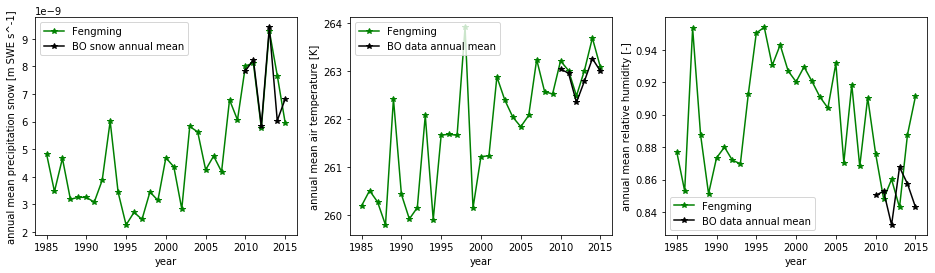

In [5]:
# check for trends in things we don't expect trends in
plt.figure(figsize=(16,4))

for i,k in enumerate([k_Ps, k_T, k_RH]):
    means_FM = daymet_FM[k].mean(1)
    #print (daymet_FM[k][0])
    plt.subplot(1,3,i+1)
    plt.plot(year_dm_FM,means_FM,'g-*',label='Fengming')
    plt.ylabel('annual mean %s'%k)
    plt.xlabel('year')
    
    if i == 0:
        means_bo = barrow_observed[k_Ps].mean(1)
        plt.plot(year_bo,means_bo, 'k-*', label='BO snow annual mean')
    if i == 1:
        means_bo = barrow_observed[k_T].mean(1)
        plt.plot(year_bo,means_bo, 'k-*', label='BO data annual mean')
    if i == 2:
        means_bo = barrow_observed[k_RH].mean(1)
        plt.plot(year_bo,means_bo, 'k-*', label='BO data annual mean')
        
    plt.legend()
    
    
plt.show()

# they look good now that wind speed has been detrended!  Look safe to use to me.
#normalization[k_qSW] = daymet[k_qSW] / daymet[k_qSW].mean()
#normalization[k_RH] = daymet[k_RH] - daymet[k_RH].mean()
#normalization[k_qLW] = daymet[k_qLW] / daymet[k_qLW].mean()
#ghcnd 
#snowtell 
#print (normalization[k_RH][0])

In [ ]:
#plt.plot(daymet[k_RH][5], 'k-*', label='BO data annual mean')
#plt.plot(daymet_FM[k_RH][0], 'r-*', label='BO data annual mean')

In [ ]:
# do we need to detrend air temp?
#Plot Observed Barrow Data 
means_bo = barrow_observed[k_T].mean(1)
plt.figure(figsize=(8,5))
plt.plot(year_bo,means_bo, 'k-*', label='BO data annual mean')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')

means = daymet_FM[k_T].mean(1)
#plt.figure()
plt.plot(year_dm_FM,means, label='raw data annual mean',color = 'r')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')


# again, do with a split at the y1th year...
# detrend the first y1 years?
polyfit = np.poly1d(np.polyfit(np.arange(0,len(means)), means, deg=1))
plt.plot(year_dm_FM, polyfit(np.arange(0,len(means))),'r--')


means_dtrended = means - polyfit(np.arange(0,len(means))) + means.mean()
plt.plot(year_dm_FM, means_dtrended,'b')
#print (means - polyfit(np.arange(0,len(means))), means.mean())

plt.show()

#Get detranded Daymet data
daymet_detrended_FM = dict()
plt.figure(figsize=(6,30))
i = 0
split_data = True
for key, d in daymet_FM.items():
    if 'time' not in key:
        plt.subplot(9,1,i+1)
        
        means = daymet_FM[key].mean(1)
        
        x= np.arange(0,len(means))
        d = []
        if (not split_data):
            #print ('Split data1: ',split_data)
            poly = np.polyfit(x,means,deg=1)
            polyfit = np.poly1d(poly)
            means_detrended = means - polyfit(x) + means.mean()

            poly_1 = np.polyfit(daymet_FM['time_yr_avg'],means,deg=1)
            polyfit_1 = np.poly1d(poly_1)
            d = np.concatenate(daymet_FM[key])
        else:
            #print ('Split data2: ',split_data, key)
            #polyfit = np.poly1d()
            poly_1 = np.polyfit(daymet_FM['time_yr_avg'][:17], means[:17], deg=1)
            poly_2 = np.polyfit(daymet_FM['time_yr_avg'][-15:], means[nyears-15:], deg=1)
            
            polyfit_A = np.poly1d(poly_1)
            polyfit_B = np.poly1d(poly_2)
            
            
            # shift the means
            center = (polyfit_A(16) + polyfit_B(nyears-15))/2.
            mean_shift = np.zeros((nyears,),'d')
            mean_shift[0:17] = polyfit_A(daymet_FM['time_yr_avg'][:17]) - center
            mean_shift[nyears-15:] = polyfit_B(daymet_FM['time_yr_avg'][nyears-15:]) - center

            means_detrended = means - mean_shift
            new_means = means - mean_shift
            poly_3 = np.polyfit(daymet_FM['time_yr_avg'],new_means,deg=1)
            polyfit_1 = np.poly1d(poly_3)
            plt.plot(year_dm_FM[:17],polyfit_A(daymet_FM['time_yr_avg'][:17]),'c')
            plt.plot(year_dm_FM[nyears-15:],polyfit_B(daymet_FM['time_yr_avg'][nyears-15:]),'m')
            #plt.plot(year_dm_FM,new_means,'m')
            #print (polyfit_B(daymet_FM['time_yr_avg'][nyears-15:]))
        #preserve snow-free and rain-free days
        if (not split_data):
            if ('snow' in key or 'rain' in key or 'precip' in key):
                ff = polyfit_1(daymet_FM['time [s]'])
                ff_dat = []
                for ix,iy in zip(d,ff):
                    if ix <iy:
                        ff_dat.append(ix)
                    else:
                        ff_dat.append(ix - iy + d.mean())
                daymet_detrended_FM[key] = np.array(ff_dat)
            else:
                daymet_detrended_FM[key] = d - polyfit_1(daymet_FM['time [s]']) + d.mean() # just get intra-annual trend, the averages will come from CESM trend
        elif ('snow' in key or 'rain' in key or 'precip' in key):
            ff_dat = []
            ff1 = polyfit_A(daymet_FM['time [s]'][:17*365])
            d1x = np.concatenate(daymet_FM[key][:17])
            
            ff2 = polyfit_B(daymet_FM['time [s]'][(nyears-14)*365:])
            d2x = np.concatenate(daymet_FM[key][nyears-14:])
            
            meanx = (polyfit_A(daymet_FM['time_yr_avg'][16]) + polyfit_B(daymet_FM['time_yr_avg'][nyears-15]))/2.
            
            #shift_m
            mean1 = ff1.mean() - center
            mean2 = ff2.mean() - center
            print ('Meansx: ',meanx, polyfit_A(np.arange(0,17))[:4], polyfit_B(np.arange(nyears-15,nyears))[:4])
            for ix,iy in zip(d1x,ff1):
                if ix <iy:
                    ff_dat.append(ix)
                else:
                    ff_dat.append(ix - iy + meanx)
            
            
            for ix,iy in zip(d2x,ff2):
                if ix <iy:
                    ff_dat.append(ix)
                else:
                    ff_dat.append(ix - iy - meanx)
            
            daymet_detrended_FM[key] = np.array(ff_dat)
            #print ('FF: ',ff, ff_dat)
        elif(False):
            print ('Never enter!')
            #print (polyfit_1(year_dm_FM))
            d1x = np.concatenate(daymet_FM[key][:17])
            d2x = np.concatenate(daymet_FM[key][nyears-14:])
            meanx = (d1x.mean() + d2x.mean())/2.
            #print (d1x.mean(), d2x.mean())
            d3 = d1x - polyfit_A(daymet_FM['time [s]'][:17*365]) + meanx
            d4 = d2x - polyfit_B(daymet_FM['time [s]'][(nyears-14)*365:]) + meanx
            daymet_detrended_FM[key] = np.concatenate((d3,d4))
            dx = np.reshape(daymet_detrended_FM[key],(-1,365)).mean(axis=1)
            plt.plot(year_dm_FM,dx,'y')

        times = [1985 + t/86400/365. for t in daymet_FM['time [s]'] ]
        d1 = np.reshape(daymet_detrended_FM[key],(-1,365)).mean(axis=1)
        #print (d1[:3])#, daymet_detrended_FM[key][:3])
        #print (d1[:10],len(d1), 17*365,(nyears-14)*365)
        plt.plot(year_dm_FM,means,'r')
        #plt.plot(year_dm_FM,means_detrended,'k')
        
        plt.plot(year_dm_FM,d1,'g.-')
        #plt.axvline(x=1989)
        
        #plt.plot(times,daymet_detrended_FM[key], 'y')
        #plt.plot(times,d, 'k--')
        plt.title(key)
        
        i = i +1
        #if (i ==1):
        #    break
        #print (6.92883102e-09 + 1.55751460e-09)

In [ ]:
#print (daymet_FM.keys())
#dat_daily['air temperature detrended [K]'] = daymet_FM[k_T] - polyfit(daymet_FM[k_time]) + daymet_FM[k_T].mean()

In [ ]:
# also load CESM RCP4.5 just for comparison sake
nyears_c, cesm45 = load_met("../CESM/CESM_4_5.h5", cycle=365)
year_c = np.arange(2006, 2006+nyears_c)

nyears_c85, cesm85 = load_met("../CESM/CESM_8_5.h5", cycle=365,adjust=1.0,adjust_rain=1.5,adjust_snow=1.6)
plt.plot(cesm85[k_P][0])

In [ ]:
#cm = colors.cm_mapper(0,3)
cm = ['b','k','r','g','c','p']
def plot(yr, ds, k, label, i, adjust=1):
    plt.plot(yr, ds[k].mean(1), label=label, color=cm[i])

    poly = np.poly1d(np.polyfit(yr, ds[k].mean(1)*adjust, deg=1))
    #print (poly(yr[0]))
    
        
    plt.plot(yr, poly(yr), color=cm[i])
    return poly

poly_trends = dict()
for dset in ['DayMet', 'SNAP', 'CESM RCP4.5', 'CESM RCP8.5']:
    poly_trends[dset] = dict()
    
def plot_all(k):
    poly_trends['DayMet'][k] = plot(year_dm_FM, daymet_FM, k, 'DayMet', 0)
    #poly_trends['SNAP'][k] = plot(year_s, snap, k, 'SNAP', 1)
    #poly_trends['CESM RCP4.5'][k] = plot(year_c, cesm45, k, 'CESM RCP4.5', 2)
    if 'wind speed' in k:
        poly_trends['CESM RCP8.5'][k] = plot(year_c, cesm85, k, 'CESM RCP8.5', 3, adjust=0.7)
    else:
        poly_trends['CESM RCP8.5'][k] = plot(year_c, cesm85, k, 'CESM RCP8.5', 3)
    #print (poly_trends['CESM RCP8.5'])
    #plt.plot(year_bo,means_bo, 'r-*', label='BO data annual mean')
    plt.xlabel('year')
    plt.ylabel("annual mean %s"%k)
    plt.legend()



In [ ]:
# check for trends
plt.figure(figsize=(16,10))
plt.subplot(231)
plot_all(k_qSW)
plt.subplot(232)
plot_all(k_Pr)
plt.subplot(233)
plot_all(k_Ps)
#plot_all(k_P)
plt.subplot(234)
plot_all(k_T)
plt.subplot(235)
plot_all(k_RH)
plt.subplot(236)

plot_all(k_U)
plt.show()

In [ ]:
# utilities
def year_generator(dat):
    print ('Shape: ',dat.shape[0])
    for i in itertools.cycle(range(dat.shape[0])):
        #print (i,dat.shape[0])
        yield dat[i,:]
       
    
def plot(years, precip_proj, trend_poly, k):
    plt.figure(figsize=(16,7))
    plt.plot(np.arange(years[0], years[-1]+1, 1.0/365), precip_proj.ravel())
    plt.plot(np.arange(year_dm_FM[0], year_dm_FM[-1]+1, 1.0/365), daymet_FM[k].ravel())

    plt.plot(year_dm_FM, poly_trends['DayMet'][k](year_dm_FM))
    plt.plot(year_dm_FM, daymet_FM[k].mean(1))
    plt.plot(years, trend_poly(years))
    plt.plot(years, precip_proj.mean(1))
    plt.xlabel('year')
    plt.ylabel(k)
    plt.show()   
    
def project_and_plot(years, trend_poly, normalized, k, operator='additive'):
    print("Projecting: %s"%k)
    if operator == 'additive':
        #print (operator, trend_poly, years[:3])
        precip_proj = np.array([pr + trend_poly(yr) - normalized.mean()*1 for yr, pr in zip(years, year_generator(normalized))])
        normalized_loc = [normalized,]*4
        print ('HERE', len(precip_proj), precip_proj.shape)
        normalized_loc = np.concatenate(np.concatenate(normalized_loc))
        if 'snow' in k or 'rain' in k or 'precip' in k:
            #print (precip_proj.shape)
            precip_proj_loc = np.concatenate(precip_proj)
            precip_proj_loc = np.array([ix if ix ==0 else iy for ix,iy in zip(normalized_loc,precip_proj_loc)])
            precip_proj = np.reshape(precip_proj_loc, (-1,365))
            #print ('HERE: ', k, precip_proj.shape)
        #we don't need pr.mean() here, so multiplied by zero
        #print (precip_proj[:10])
    elif operator == 'multiplicative':
        #print (operator, trend_poly, years)
        precip_proj = np.array([pr*trend_poly(yr) for yr, pr in zip(years, year_generator(normalized))])
    elif (operator == 'none'):
        precip_proj = np.array([pr for yr, pr in zip(years, year_generator(normalized))])
    else:
        raise RuntimeError('invalid operator, must be "additive" or "multiplicative"')
    
    if 'humidity' in k:
        precip_proj = np.clip(precip_proj,0.8,1.)
            
    if 'shortwave' in k:
        precip_proj = np.clip(precip_proj,0.0,1000.)
    if 'precipitation' in k:
        precip_proj = np.clip(precip_proj,0.0,1000.)
        #print (precip_proj)
    plot(years, precip_proj, trend_poly, k)
    #print (precip_proj.shape)
    # check min/max are reasonable
    #print(precip_proj.min(), precip_proj.max())
    return precip_proj  


In [ ]:
# projected dataset
proj = dict()


In [ ]:
print (daymet_FM.keys())
print (poly_trends['CESM RCP8.5'].keys())
cesm_keys= poly_trends['CESM RCP8.5'].keys()

In [ ]:
# use CESM RCP8.5 air temperatures, RH, and incoming SW

for key in daymet_FM.keys():
    operation = 'additive'
    if key == 'air temperature [K]':
        operation = 'additive'
    if key == 'precipitation [m s^-1]':
        continue
    if key in cesm_keys:
        print ('-------_*************___')
        print (operation,key)
        #normalized = daymet_FM[key]
        #proj[key] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][key], normalized, key, operator=operation)
        normalized = np.reshape(daymet_detrended_FM[key],(-1,365))
        #print ('L2',len(normalized),normalized[0])
        #xd = np.concatenate(normalized)
        #xd = np.concatenate((xd[365*21:], xd[:365*21]))
        ##print (len(xd))
        #xd = np.reshape(xd,(-1,365))
        #normalized = xd
        #print ('L1',len(xd))
        #-print ('1: ',key, normalized[0], np.max(normalized[0]))
        proj[key] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][key], normalized, key, operator=operation)
        #print ('2: ',key, proj[key][0], np.max(proj[key][0]))
        #break
normalized = daymet_FM[k_qLW]
proj[k_qLW] = np.array([d for i,d in zip(range(len(year_c)), year_generator(daymet_FM[k_qLW]))])

#print (proj.keys())
proj[k_P] = proj[k_Ps] + proj[k_Pr]


In [ ]:
#print (proj[k_P][:365])
print (proj[k_Pr].mean(1)*1000*86400*365)
print (proj[k_Ps].mean(1)*1000*86400*365)

In [ ]:
#KEY:  precipitation rain [m s^-1]
dm_rain = np.array([ 72.79096592, 110.55055503, 114.82002462,  82.97934993, 208.64983664,127.93558478,  18.65690432,  46.10319296, 124.51101603, 102.51351196, 44.25179027,  78.59970379, 131.95548701,  98.91865558,  76.25069113, 146.24253656, 117.03815901, 122.08777453, 110.38177368, 141.18277125, 119.55024913,  86.70310984,  37.80123558,  72.94146858, 139.26476378,81.06552691, 124.23914874, 142.16411071, 172.45332413, 139.65417579,118.96055906])
#KEY:  precipitation snow [m SWE s^-1]
dm_snow = np.array([165.93509606, 117.60693865, 154.77135404, 106.22903093, 108.31908398,
 108.62745183, 101.60821946, 127.96004789, 195.45200173, 111.43857089,
  72.86458601,  87.06901924,  78.64817042, 109.88018556,  99.62676871,
 147.87504708, 136.90854833,  88.30258985, 181.5789007,  174.0376379,
 130.68914053, 145.37284268, 126.14965788, 205.75994619, 183.40066772,
 243.96461398, 245.4043054,  171.97690359, 277.72559163, 228.95423896,174.89499953] )

In [ ]:
plt.plot(proj[k_Pr].mean(1)*1000*86400*365,'r')
#plt.plot(dm_rain,'b')

plt.plot(proj[k_Ps].mean(1)*1000*86400*365,'m')
#plt.plot(dm_snow,'g')

print (proj[k_Pr].mean(1)*1000*86400*365)

In [ ]:

proj[k_Ps] = np.where(proj[k_T] >= 273.15, 0., proj[k_P])
proj[k_Pr] = np.where(proj[k_T] > 273.15, proj[k_P], 0)

plt.figure(figsize=(16,7))
#plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_Ps].ravel(), 'c')
#plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_Pr].ravel(), 'b')


snow = np.reshape(proj[k_Ps],(-1,365)).mean(1)*1000*86400*365
rain = np.reshape(proj[k_Pr],(-1,365)).mean(1)*1000*86400*365
total_precip = snow + rain
Precip = proj[k_P].mean(1)*1000*86400*365
#daymet_FM[]
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.), snow, 'c')
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.), rain, 'b')
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.), total_precip, 'k')
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.), Precip, 'r.')
print (rain)
#print (total_precip)
plt.show()


In [ ]:
proj[k_U] = np.where(proj[k_U] <0, 0., proj[k_U])

In [ ]:

# save to file
times = np.arange(86400./2, len(year_c) * 365 * 86400 +1, 86400)
assert(len(times) == 365*95)

#Used smooth historical data
with h5py.File("CESM-RCP8.5-2006-2100_dm1985-2015-FM.h5",'w') as fout:
    fout.create_dataset(k_time, data=times)
    for k in proj.keys():
        print (k)
        fout.create_dataset(k, data=proj[k].ravel())


In [ ]:
# Same forcing file, 100 year projection, but time starts from 2006
x = 6.622128E8 - 43200
times = np.arange(86400./2, len(year_c) * 365 * 86400 +1, 86400)
times = [x +t for t in times]
print (len(times))
assert(len(times) == 365*95)
 # 2006 year

#x = x/86400. + 0.5
print ((x/86400. +0.5)/365. , times[0]/86400./365.)

#Used smooth historical data
with h5py.File("CESM-RCP8.5-2006-2100_dm1985-2015-FM_2006.h5",'w') as fout:
    fout.create_dataset(k_time, data=times)
    for k in proj.keys():
        print (k)
        fout.create_dataset(k, data=proj[k].ravel())

In [ ]:
6.622128E8 - 6.62256E8